# Zee: Zero Effort Crowdsourcing for Indoor Localization

This notebook implements the algorithm described in the Zee paper.

In [1]:
from dataclasses import dataclass

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import json
import shapely
import sklearn
import scipy
import shapely.vectorized
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

%matplotlib inline

In [164]:
from sklearn.neighbors import NearestNeighbors

In [3]:
PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [4]:
# type: ignore
from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

In [5]:
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The code is located in ./../../code


In [6]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.sensors import estimate_acceleration_heading, estimate_heading_from_waypoints

In [7]:
from pathlib import Path

In [8]:
from glob import glob

## Read Train/Test Assignment

In [9]:
train_test_assignment = pd.read_csv("../../data/output/train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype("category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype("category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype("category")

## Context Definition

Define Zee context, which includes
  * Paths to train track data./
  * Floor map description.

In [10]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "B1"

path_data_dir = Path(f"../../data/train")

In [11]:
train_tracks = train_test_assignment[
    (train_test_assignment["site_id"] == site_id) 
    & (train_test_assignment["floor_id"] == floor_id)
    & (train_test_assignment["dataset"] == "train")]

In [12]:
def get_track_filepaths(assignment_df: pd.DataFrame, base_data_dir: str | Path, suffix: str) -> list[str]:
  if isinstance(base_data_dir, str):
    base_data_dir = Path(base_data_dir)
    
  result = []

  for _, row in assignment_df.iterrows():
    file_path = base_data_dir / row["site_id"] / row["floor_id"] / (str(row["track_id"]) + suffix)
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)
    
  return result

In [13]:
train_files = get_track_filepaths(train_tracks, path_data_dir, suffix=".txt")

In [14]:
# Reading floor map data
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

### Floormap Extraction

In [15]:
transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

## Reading Path Data

In [16]:
path_datas = read_data_file(train_files[0])

In [17]:
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint

In [18]:
gt_times = path_datas.waypoint[:, 0]
gt_location = path_datas.waypoint[:, 1:]

## Floor Map Rotation w.r.t the North

In [193]:
acce, heading = estimate_acceleration_heading(path_datas.acce, path_datas.magn)
heading_timestamps = magn_datas[:, 0]
heading = -heading % 360

In [194]:
heading_values, acce_earths = heading, acce

In [195]:
waypoint_heading = estimate_heading_from_waypoints(path_datas.waypoint[:, 1:3])
waypoint_timestamps = path_datas.waypoint[:, 0]
assert len(waypoint_heading) == len(waypoint_timestamps) - 1

In [119]:
waypoint_sensor_headings = np.zeros_like(waypoint_heading, dtype=np.float32)

for i in range(len(waypoint_heading)):
  prev_time, next_time = waypoint_timestamps[i], waypoint_timestamps[i + 1]
  segment_heading = heading[(heading_timestamps >= prev_time) & (heading_timestamps < next_time)]
  
  if segment_heading.shape[0] == 0:
    waypoint_sensor_headings[i] = np.nan
  else:
    waypoint_sensor_headings[i] = np.mean(segment_heading)

In [120]:
# TODO: Rotation angle estimation using multiple data points

gt_x = gt_location[:, 0]
gt_y = gt_location[:, 1]

k1 = (gt_y[1] - gt_y[0]) / (gt_x[1] - gt_x[0])
k2 = np.tan(np.radians(heading[0]))

rotation_angle = np.arctan((k1 - k2) / (1 + k1 * k2))
print(
    f"rotation_angle: {rotation_angle:.2f} (rad), {np.degrees(rotation_angle):.2f} (deg)"
)

rotation_angle: -1.26 (rad), -72.31 (deg)


In [121]:
valid_mask = ~np.isnan(waypoint_sensor_headings)
valid_waypoint_heading = waypoint_heading[valid_mask]
valid_waypoint_sensor_heading = waypoint_sensor_headings[valid_mask]

In [122]:
print((valid_waypoint_heading - valid_waypoint_sensor_heading).mean())

-168.30710606382328


## Zee: Counting Steps

In [123]:
ts = path_datas.acce[:, 0].astype(np.int64)
acce_x = acce[:, 0]
acce_y = acce[:, 1]
acce_z = acce[:, 2]

acce_magn = np.linalg.norm(acce, axis=1)

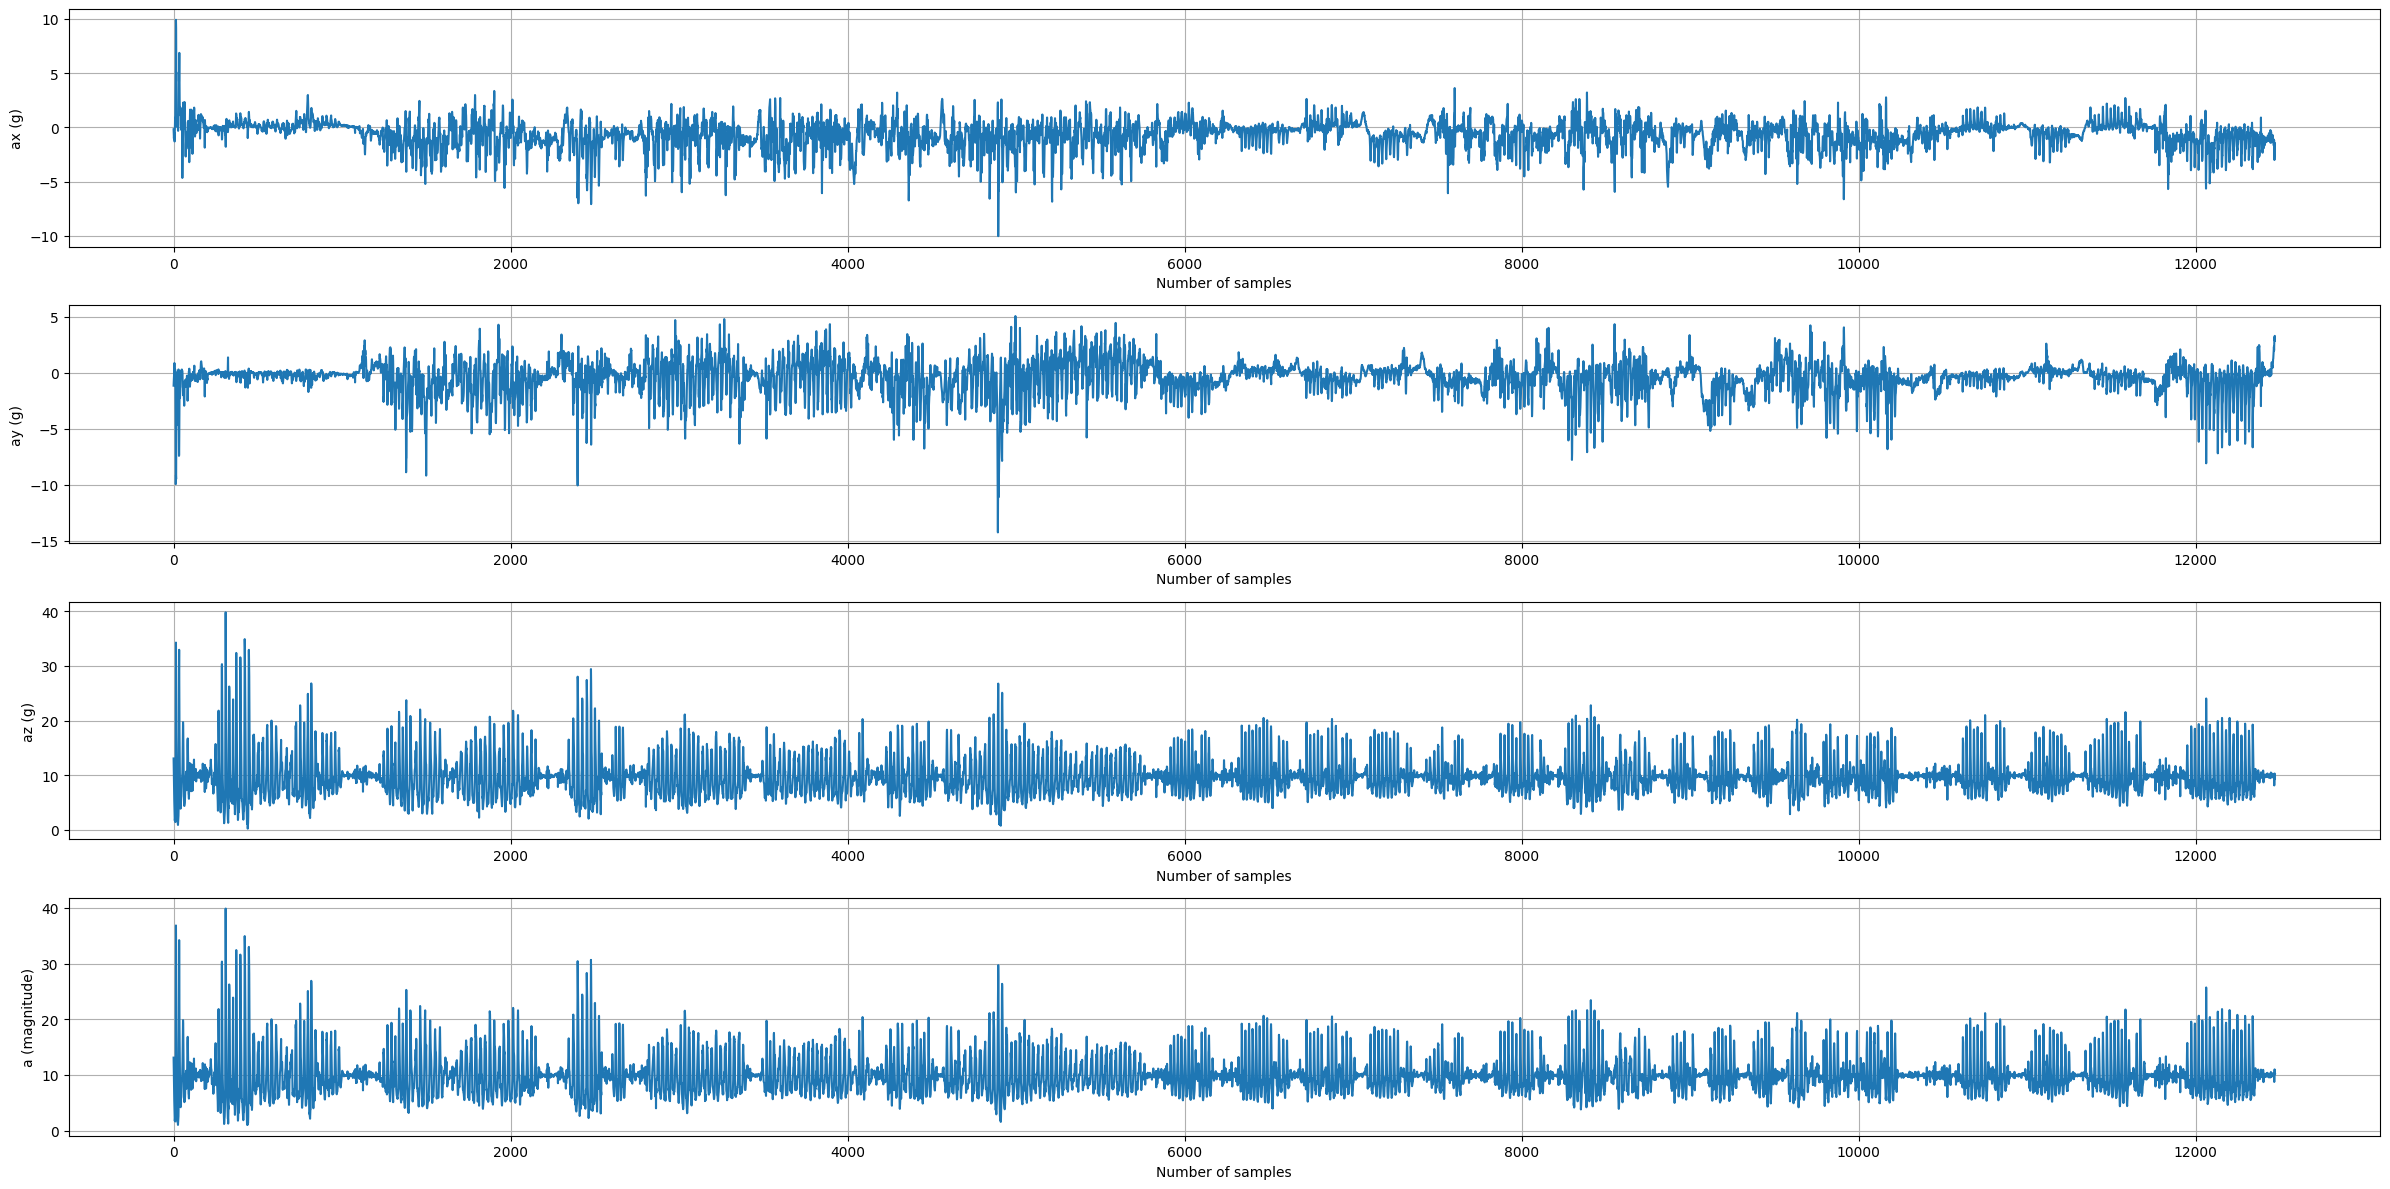

In [124]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(24, 12),
)

ax1.plot(acce_x)
ax1.set_ylabel("ax (g)")
ax1.set_xlabel("Number of samples")

ax2.plot(acce_y)
ax2.set_ylabel("ay (g)")
ax2.set_xlabel("Number of samples")

ax3.plot(acce_z)
ax3.set_ylabel("az (g)")
ax3.set_xlabel("Number of samples")

ax4.plot(acce_magn)
ax4.set_ylabel("a (magnitude)")
ax4.set_xlabel("Number of samples")

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.tight_layout()
plt.show()

### Normalized Auto-correlation based Step Counting (NASC)

* The intuition behind NASC is that if the user is walking, then the auto-correlation will spike at the correct periodicity of the walker.

In [125]:
def norm_acf(a, m, t):
  mu_m, sigma_m = np.mean(a[m:m + t], axis=0), np.std(a[m:m + t], axis=0)
  mu_mt, sigma_mt = np.mean(a[m + t:m + t * 2],
                            axis=0), np.std(a[m + t:m + t * 2], axis=0)

  n_acf = (np.sum((a[m:m + t] - mu_m) * (a[m + t:m + t * 2] - mu_mt), axis=0) /
           t / sigma_m / sigma_mt)

  return np.mean(n_acf)


In [126]:
acc_sampling_freq = ts.shape[0] / (ts[-1] / 1000 - ts[0] / 1000)
print("The sampling frequency of accelerometer is {:.2f}Hz".format(acc_sampling_freq))

The sampling frequency of accelerometer is 50.36Hz


In [127]:
def max_norm_acf(a, m, t_min=40, t_max=100):
  """
  Finding the maximum normalized auto-correlation.
  """
  t_best = t_min
  n_acf_best = norm_acf(a, m, t_best)
  for t in range(t_min, t_max + 1):
    n_acf = norm_acf(a, m, t)
    if n_acf > n_acf_best:
      t_best = t
      n_acf_best = n_acf
  return n_acf_best, t_best


In [128]:
STATE_IDLE = "IDLE"
STATE_WALKING = "WALKING"


def get_state(acce, m, prev_state=None, prev_t_opt=None):
  if prev_t_opt is not None:
    t_min, t_max = max(40, prev_t_opt - 10), min(100, prev_t_opt + 10)
  else:
    t_min, t_max = 40, 100

  n_acf, t_opt = max_norm_acf(acce, m=m, t_min=t_min, t_max=t_max)

  sigma = np.mean(np.std(acce[m:m + t_opt], axis=0))
  if sigma < 0.01:
    return STATE_IDLE, t_opt

  if n_acf > 0.7:
    return STATE_WALKING, t_opt

  return prev_state, t_opt


In [129]:
get_state(acce, m=200)

(None, 60)

## Zee: Estimating Heading Offset Range

### Estimating Heading

* Heading is the $\theta$ from the paper, which is the compass value.

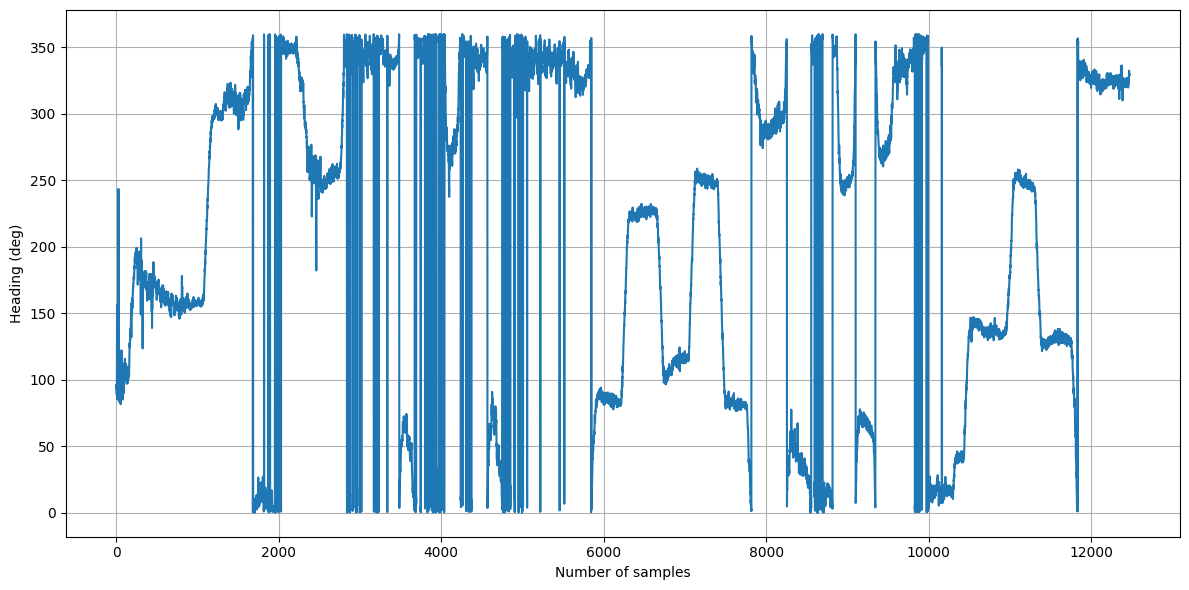

In [130]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.plot(-heading % 360, label="heading")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()

plt.tight_layout()
plt.show()

### Spectrum of a Typical Walk

* After observing the Fourier transform across several uses and placements, the authors discovered an interesting fact: *the second harmonic is either completely absent or is extremely weak in the accelerations experienced by the phone in the direction perpendicular to the user's walk. It is however always present and dominant in the direction parallel to the user's walk.*
* What are implications of this observation? - We can estimate the possible values for the sum `magnetic_offset + heading_offset + compass` from the magnitude of the second harmonic in teh Fourier transform along north `Fy` and along west `Fx`
  * `magnetic_offset + heading_offset + compass = arctan(Fx/Fy)`
  * OR `magnetic_offset + heading_offset + compass = arctan(Fx/Fy) + 180`

In [131]:
def show_spectrum(signal_data, fs, figsize=(10, 6), ax1=None, ax2=None):
  n_samples = len(signal_data)
  duration = n_samples / fs
  t = np.linspace(0, duration, int(fs * duration), endpoint=False)

  frequencies, spectrum = scipy.signal.periodogram(signal_data, fs=fs)

  if ax1 is None and ax2 is None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

  ax1.plot(t, signal_data)
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Amplitude")
  ax1.set_title("Time Domain Signal")

  ax2.plot(frequencies, spectrum)
  ax2.set_xlabel("Frequency (Hz)")
  ax2.set_ylabel("Magnitude")
  ax2.set_title("Frequency Spectrum")

  plt.tight_layout()


In [132]:
def find_fundamental_frequency(frequencies, spectrum):
  idx = np.argmax(spectrum)
  return frequencies[idx], spectrum[idx]


In [133]:
def find_fundamental_frequency_and_harmonics(frequencies,
                                             spectrum,
                                             harmonics=(2, 3, 4)):
  fundamental_frequency, amplitude = find_fundamental_frequency(
      frequencies, spectrum)
  harmonics_found = [
      harmonic for harmonic in harmonics
      if harmonic * fundamental_frequency in frequencies
  ]
  return fundamental_frequency, amplitude, harmonics_found


Fundamental Frequency: 2.2 Hz, Magnitude: 82.29
Harmonics Found: [2, 3, 4]


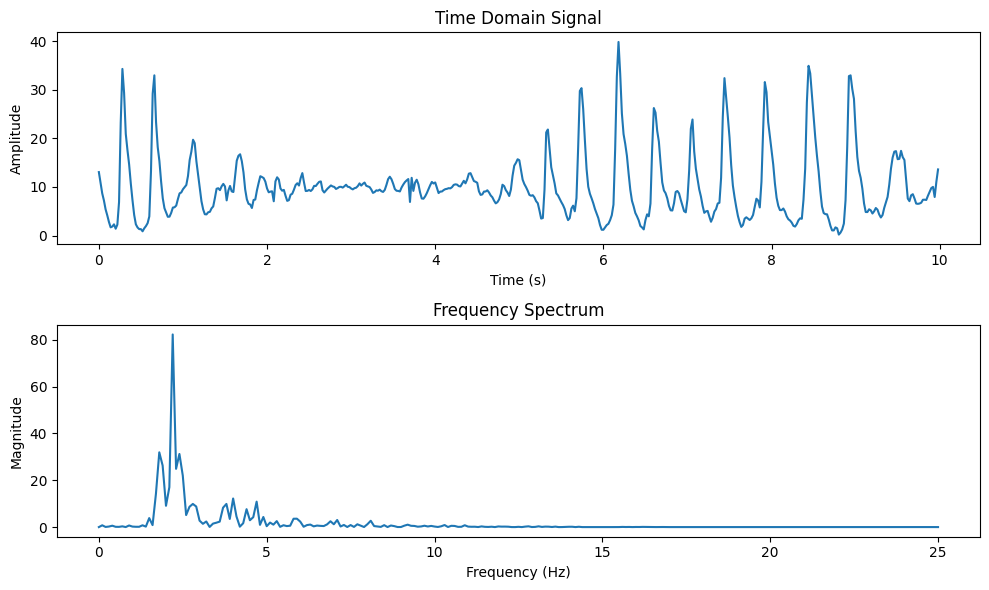

In [134]:
show_spectrum(acce_z[:500], fs=50)

# Find the fundamental frequency and its harmonics
frequencies, spectrum = scipy.signal.periodogram(acce_z[:500], fs=50)
harmonics = [2, 3, 4]
(
    fundamental_frequency,
    amplitude,
    harmonics_found,
) = find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics)

print(
    f"Fundamental Frequency: {fundamental_frequency} Hz, Magnitude: {amplitude:.2f}"
)
print(f"Harmonics Found: {harmonics_found}")

* Next, we try a different approach to find `Fx` (the magnitude of the second harmonic in the Fourier transform along the West) and `Fy` (the magnitude of the second harmonic in the Fourier transform along the North).
  * We map the acceleration vector to the Earth coordinate system, in which x-axis points East, y-axis points North and z-axis points to the sky.
  * Then `Fx = -(F along the x-axis)`, `Fy = F along the y axis`

In [135]:
parallel = np.linalg.norm(acce[:, :2], axis=1)
perpendicular = acce[:, 2]

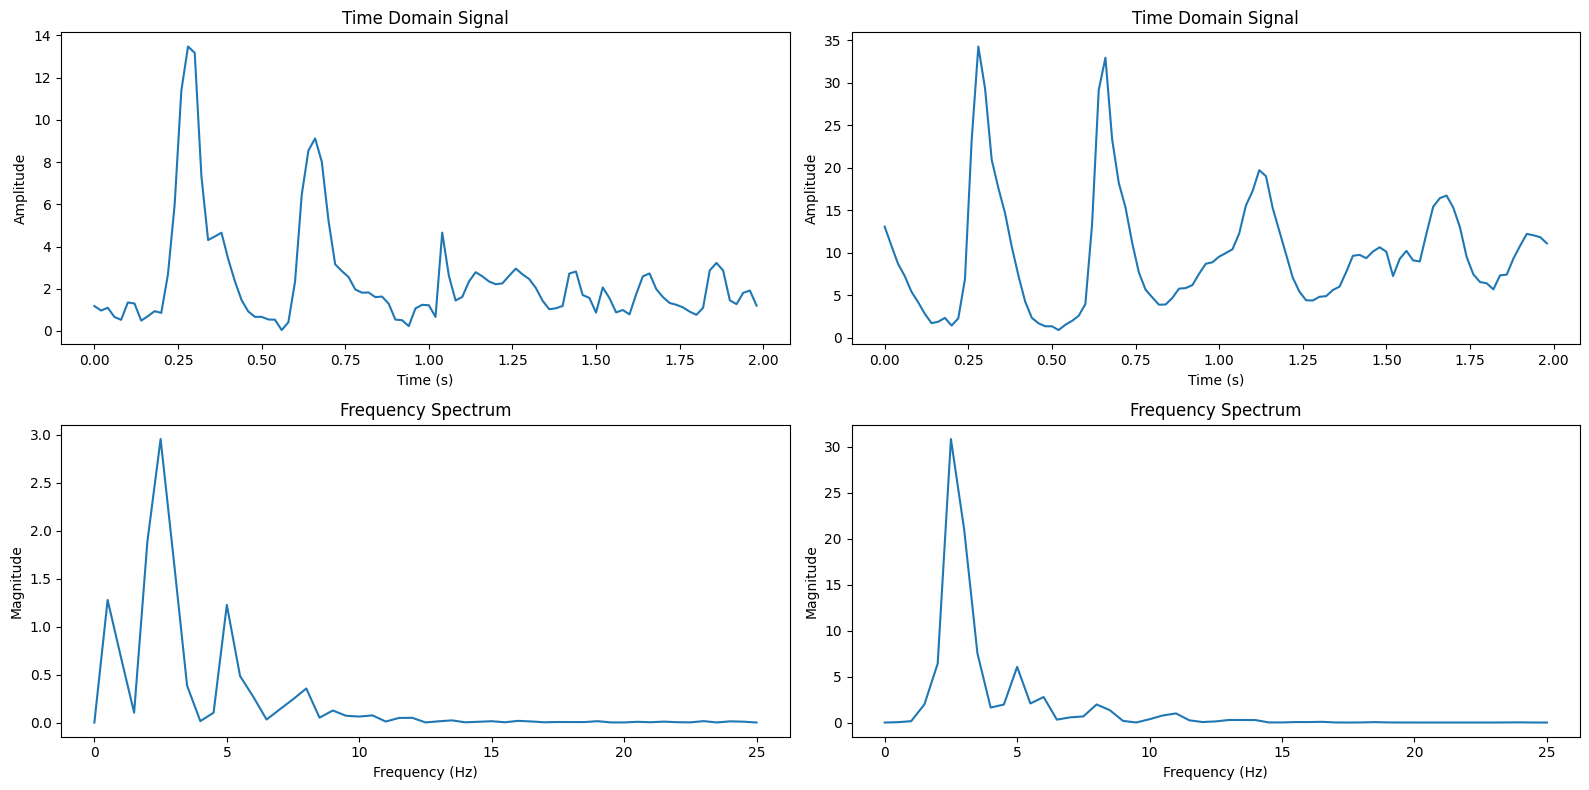

In [136]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

show_spectrum(parallel[:100], fs=50, ax1=axes[0][0], ax2=axes[1][0])
show_spectrum(perpendicular[:100], fs=50, ax1=axes[0][1], ax2=axes[1][1])

plt.show()

In [196]:
def estimate_heading_offset(acce_earths, fs):
  parallel = np.linalg.norm(acce_earths[:, :2], axis=1)
  f_parallel, amp_parallel = scipy.signal.periodogram(parallel, fs=fs)
  idx = np.argmax(amp_parallel)
  fx = -1 * acce_earths[idx * 2, 0]
  fy = acce_earths[idx * 2, 1]

  return np.degrees(np.arctan(fx / fy) % (2 * np.pi))

In [198]:
estimate_heading_offset(acce_earths[:100], fs=50)

272.52309178554714

### Magnetic Offsets

* Heading computation from ground-truth location

In [ ]:
# TODO: Use all train data for heading computation

In [199]:
ts = path_datas.acce[:, 0]
min_time, max_time, n_samples = ts.min(), ts.max(), len(ts)

In [200]:
gt_ts = path_datas.waypoint[:-1, 0]
gt_ts_frac = (gt_ts - min_time) / (max_time - min_time) * n_samples
gt_ts_frac = np.rint(np.clip(gt_ts_frac, a_min=0, a_max=n_samples)).astype(np.int64)

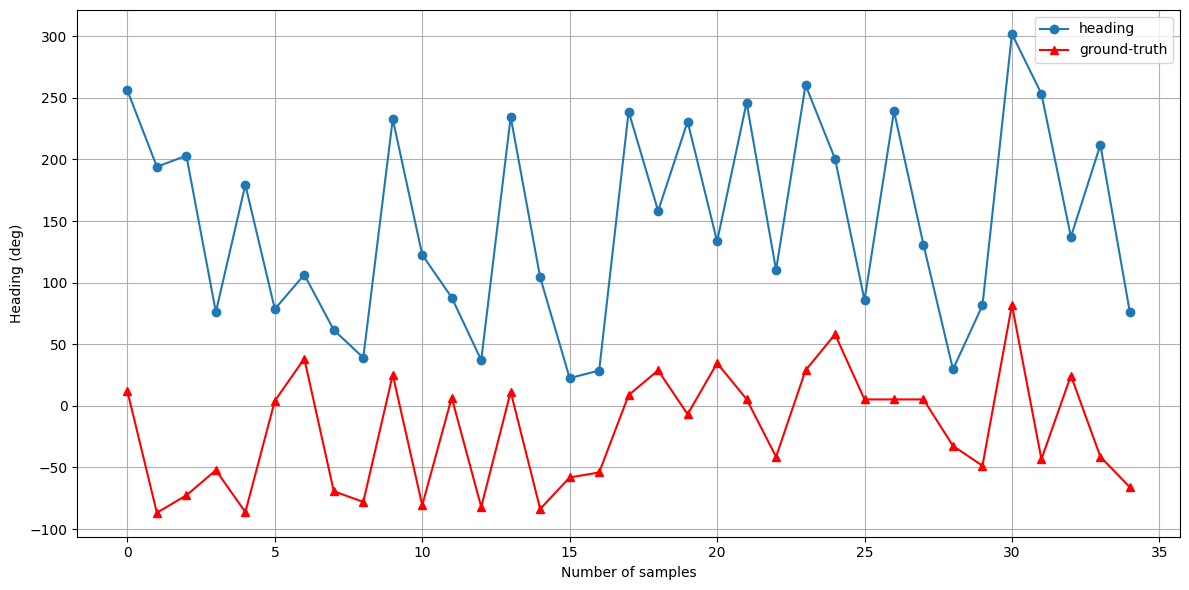

In [201]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.plot(waypoint_sensor_headings, marker="o", label="heading")
ax.plot(waypoint_heading, marker="^", color="red", label="ground-truth")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

* We have to rotate the original coordinate system into a coordinate system in which `Ox` points North.
* The equation for rotation could be found here: https://en.wikipedia.org/wiki/Rotation_of_axes_in_two_dimensions

In [202]:
def rotate(xs, ys, a):
  xs = np.atleast_1d(xs)
  ys = np.atleast_1d(ys)

  r_xs = xs * np.cos(a) + ys * np.sin(a)
  r_ys = -1 * xs * np.sin(a) + ys * np.cos(a)

  return r_xs, r_ys


# sanity check
r_xs, r_ys = rotate(np.sqrt(3), 1, np.pi / 6)
assert np.isclose(r_xs[0], 2)
assert np.isclose(r_ys[0], 0)

r_xs, r_ys = rotate(7, 7, -np.pi / 2)
assert np.isclose(-7, r_xs[0])
assert np.isclose(7, r_ys[0])

In [323]:
def inverse_rotate(xs, ys, a):
  ir_xs = xs * np.cos(a) - ys * np.sin(a)
  ir_ys = xs * np.sin(a) + ys * np.cos(a)
  return ir_xs, ir_ys

In [325]:
rotation_angle = (waypoint_heading - waypoint_sensor_headings).mean()
rotation_angle_radians = np.radians(rotation_angle)
print(f"Angle: {rotation_angle:.2f} (degree), {rotation_angle_radians:.2f} (rad)")

Angle: -168.31 (degree), -2.94 (rad)


In [327]:
r_gt_x, r_gt_y = rotate(gt_location[:, 0], gt_location[:, 1], rotation_angle_radians)

In [328]:
r_gt_heading_values = np.degrees(
    np.arctan((r_gt_y[1:] - r_gt_y[:-1]) / (r_gt_x[1:] - r_gt_x[:-1])))
r_gt_heading_values = (r_gt_heading_values + 180) % 180  # avoid obstue angle

## Augmented Particle Filter

### Map Data Preprocessing

In [330]:
def transform_rotation(rotation_angle):

  rotation_angle_radians = np.radians(rotation_angle)

  def impl(coords):
    r_xs, r_ys = rotate(coords[:, 0], coords[:, 1], rotation_angle_radians)
    return np.vstack((r_xs, r_ys)).T

  return impl


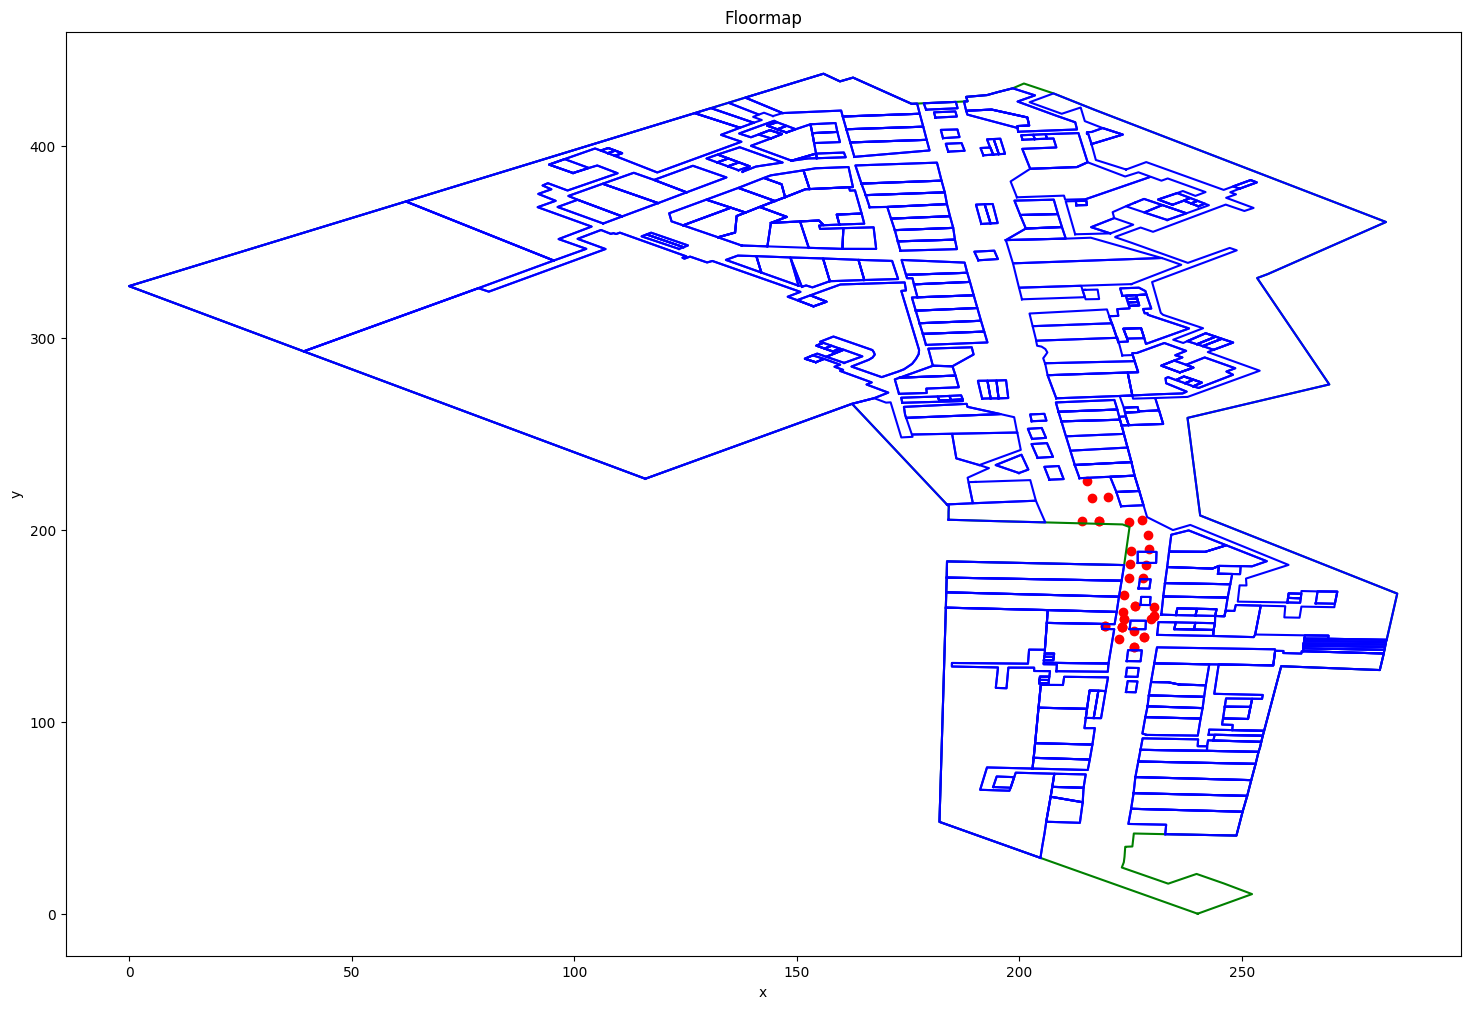

In [331]:
transform_func = transform_rotation(rotation_angle)
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
r_gt_location = transform_func(gt_location)
scale(
    r_gt_location, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True
)
ax.scatter(r_gt_location[:, 0], r_gt_location[:, 1], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

#### Search Space Extraction

* Search space is the space occupied by the floor excluding the space occupied by the stores.

In [332]:
union_floor_polygon = shapely_ops.unary_union(floor_polygons)
union_store_polygon = shapely_ops.unary_union(store_polygons)
floor_search_space = union_floor_polygon.difference(union_store_polygon)

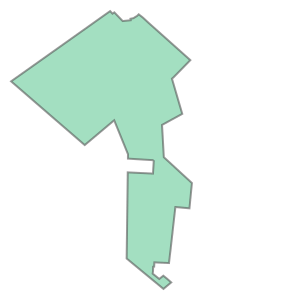

In [333]:
union_floor_polygon

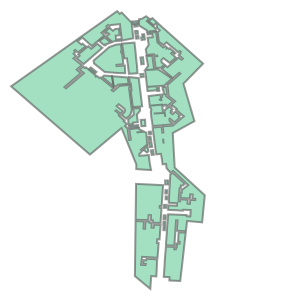

In [334]:
union_store_polygon

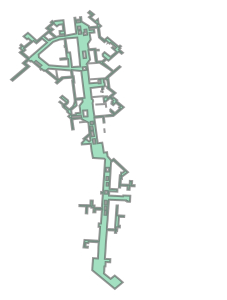

In [335]:
floor_search_space

In [336]:
# Generate search grid

grid_resolution = 2  # 5 meters
grid_xs = np.arange(0, width_meter, grid_resolution) + grid_resolution / 2
grid_ys = np.arange(0, height_meter, grid_resolution) + grid_resolution / 2

grid_x, grid_y = np.meshgrid(grid_xs, grid_ys)

In [337]:
search_space_mask = shapely.vectorized.contains(floor_search_space, grid_x, grid_y)
ss_x, ss_y = grid_x[search_space_mask], grid_y[search_space_mask]

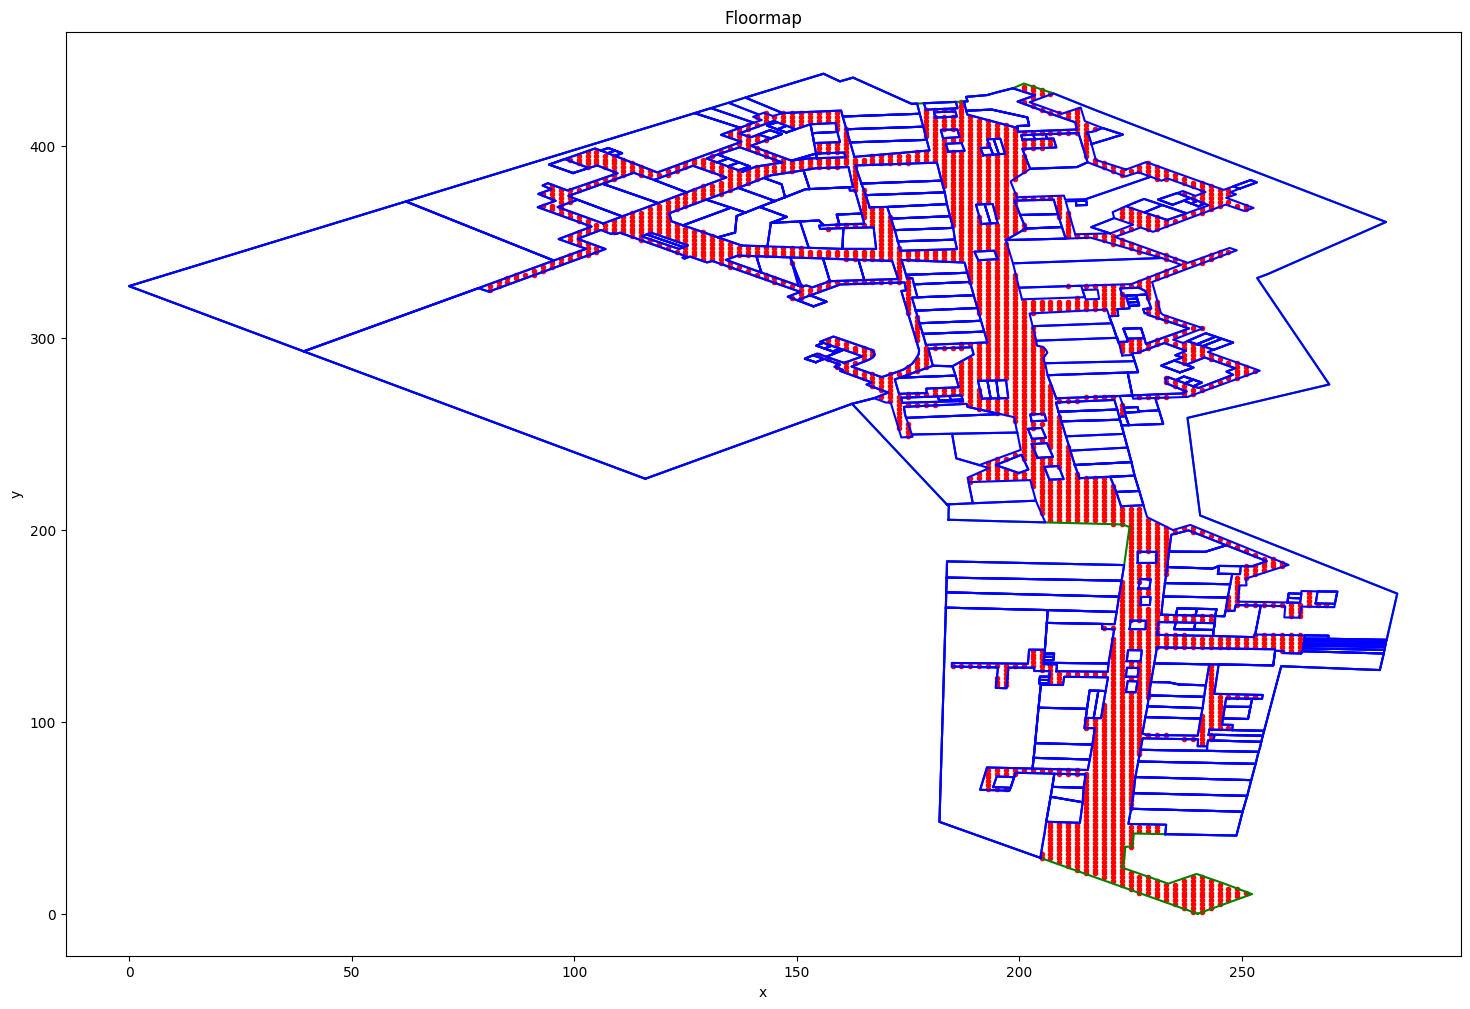

In [338]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding search grid
ax.scatter(ss_x, ss_y, marker=".", color="red", label="ss")

plt.ticklabel_format(useOffset=False)
plt.show()

In [339]:
X_ss = np.vstack((ss_x, ss_y)).T

In [340]:
nn = NearestNeighbors(n_neighbors=5, radius=5, algorithm="ball_tree")

In [341]:
_ = nn.fit(X_ss)

### Implementation of APF

In [488]:
from dataclasses import field

In [489]:
@dataclass
class APFStep(object):
  # particles being considered in this step
  particles: np.ndarray
  # sample_index is the index of the sample in the IMU data sequence
  sample_index: int
  # parent[i] = j iff the j-the particle in the previous step is the parent of the current particle
  parent: np.ndarray
  # keep_mask[i] = True if the i-th particle is kept, i.e. it has at least 1 child in the next step
  keep_mask: np.ndarray = field(init=False)

  def __post_init__(self):
    self.keep_mask = np.array([False] * len(self.particles))

In [519]:
ss_n

2614

In [520]:
# Initialization

ss_n = len(ss_x)
n_particles = 250000

# Range for stride length
stride_length_min, stride_length_max = 0.5, 1.2

particles = np.zeros((n_particles, 4), dtype=np.float64)
weights = np.ones(n_particles) / n_particles

# Initial random position
ss_idx = np.random.randint(ss_n, size=n_particles)
particles[:, 0] = ss_x[ss_idx]
particles[:, 1] = ss_y[ss_idx]

# Initial random stride length
particles[:, 2] = np.random.uniform(
    stride_length_min, stride_length_max, size=n_particles
)

# Initial placement offset
heading_offset = estimate_heading_offset(acce_earths[:1], fs=50)
heading = heading_values[0]
alpha = heading_offset - heading
placement_offsets_1 = np.random.normal(alpha, 10, size=n_particles//2)
placement_offsets_2 = np.random.normal(alpha + 180, 10, size=n_particles//2)
particles[:, 3] = np.hstack((placement_offsets_1, placement_offsets_2))
np.random.shuffle(particles[:, 3])

In [521]:
acce = np.sqrt(np.sum(path_datas.acce[:, 1:] ** 2, axis=1))

turn_delta_heading = 20  # 20 degrees
magnetic_offset_error_scale = 5   # 5 degrees
stride_length_variation = 0.1   # 10 percents

step_idx = 0
it = 0
prev_state = None
prev_t_opt = None
particle_indices = np.arange(n_particles)

# eliminated = true if the particle was eliminated in the next step, false otherwise
parent = np.ones(n_particles, dtype=np.int32) * -1
keep_mask = np.array([True] * n_particles)
history = [
  APFStep(particles=particles, parent=parent, sample_index=0)
]

while True:
  it += 1

  if (prev_t_opt is not None) and (step_idx + 2 * prev_t_opt >= len(acce)):
    break

  state, t_opt = get_state(
    acce, m=step_idx, prev_state=prev_state, prev_t_opt=prev_t_opt
  )

  step_freq = t_opt // 2
  next_step_idx = step_idx + step_freq

  print(
    f"Iteration {it}: state = {state}, step_freq = {step_freq} samples/step, sample_idx = {step_idx} -> {next_step_idx}"
  )

  if state == "WALKING":
    last_apf_step = history[-1]

    last_particles = last_apf_step.particles.copy()
    particles = last_particles.copy()
    parent = np.ones(n_particles, dtype=np.int32) * -1
    
    # Update
    magnetic_offset = np.random.normal(loc=0, scale=np.radians(magnetic_offset_error_scale), size=n_particles)
    stride_length = particles[:, 2] + np.random.uniform(-stride_length_variation, stride_length_variation, size=n_particles) * particles[:, 2]

    # Predict with fractional update if possible
    turn_points = []
    for i in range(step_idx + 1, next_step_idx):
      if np.abs(heading_values[i] - heading_values[i - 1]) > turn_delta_heading:
        turn_points.append(i)

    if len(turn_points) == 0:
      # No fractional update
      heading = np.radians(heading_values[step_idx:next_step_idx].mean())
      angle = particles[:, 3] + heading + magnetic_offset
      particles[:, 0] = particles[:, 0] + stride_length * np.cos(angle)
      particles[:, 1] = particles[:, 1] + stride_length * np.sin(angle)
    else:
      # Fractional update
      turn_points = [step_idx, *turn_points, next_step_idx]
      for i, j in zip(turn_points[:-1], turn_points[1:]):
        heading = np.radians(heading_values[i:j].mean())
        angle = particles[:, 3] + heading + magnetic_offset
        particles[:, 0] = particles[:, 0] + stride_length * (j - i) / step_freq * np.cos(angle)
        particles[:, 1] = particles[:, 1] + stride_length * (j - i) / step_freq * np.sin(angle)

    # Resampling
    # 1/ In order to replace each eliminated particle, a new particle is randomly chosen from the particle set at the previous step AND updated.
    # 2/ To enable traceback, each particle after the k-th step maintains a link to its parent particle
    dists, indices = nn.kneighbors(particles[:, :2], n_neighbors=1)
    keep = dists[:, 0] < grid_resolution
    n_eliminated = np.count_nonzero(~keep)

    parent[keep] = particle_indices[keep]
    
    if n_eliminated > 0:
      # TODO: Try to fill these things for at least some times
      parent[~keep] = np.random.choice(particle_indices, size=n_eliminated)
      particles[~keep] = last_particles[parent[~keep]]

      magnetic_offset = np.random.normal(loc=0, scale=np.radians(magnetic_offset_error_scale), size=n_eliminated)
      stride_length = particles[~keep, 2] * (1 + np.random.uniform(-stride_length_variation, stride_length_variation, size=n_eliminated))

      # TODO: This fractional update is too vulnerable to noise, should be skipped
      turn_points = []
      for i in range(step_idx + 1, next_step_idx):
        if np.abs(heading_values[i] - heading_values[i - 1]) > turn_delta_heading:
          turn_points.append(i)

      if len(turn_points) == 0:
        # No fractional update
        heading = np.radians(heading_values[step_idx:next_step_idx].mean())
        angle = particles[~keep, 3] + heading + magnetic_offset
        particles[~keep, 0] = particles[~keep, 0] + stride_length * np.cos(angle)
        particles[~keep, 1] = particles[~keep, 1] + stride_length * np.sin(angle)
      else:
        # Fractional update
        turn_points = [step_idx, *turn_points, next_step_idx]
        for i, j in zip(turn_points[:-1], turn_points[1:]):
          heading = np.radians(heading_values[i:j].mean())
          angle = particles[~keep, 3] + heading + magnetic_offset
          particles[~keep, 0] = particles[~keep, 0] + stride_length * (j - i) / step_freq * np.cos(angle)
          particles[~keep, 1] = particles[~keep, 1] + stride_length * (j - i) / step_freq * np.sin(angle)

      # This method is time consuming
      dists, indices = nn.kneighbors(particles[:, :2], n_neighbors=1)
      keep = dists[:, 0] < grid_resolution
      n_eliminated = np.count_nonzero(~keep)

    # Append history
    history.append(APFStep(particles=particles, parent=parent, sample_index=next_step_idx))

  prev_state = state
  prev_t_opt = t_opt
  step_idx = next_step_idx

Iteration 1: state = None, step_freq = 20 samples/step, sample_idx = 0 -> 20
Iteration 2: state = WALKING, step_freq = 25 samples/step, sample_idx = 20 -> 45
Iteration 3: state = WALKING, step_freq = 21 samples/step, sample_idx = 45 -> 66
Iteration 4: state = WALKING, step_freq = 23 samples/step, sample_idx = 66 -> 89
Iteration 5: state = WALKING, step_freq = 26 samples/step, sample_idx = 89 -> 115
Iteration 6: state = WALKING, step_freq = 26 samples/step, sample_idx = 115 -> 141
Iteration 7: state = WALKING, step_freq = 21 samples/step, sample_idx = 141 -> 162
Iteration 8: state = WALKING, step_freq = 21 samples/step, sample_idx = 162 -> 183
Iteration 9: state = WALKING, step_freq = 24 samples/step, sample_idx = 183 -> 207
Iteration 10: state = WALKING, step_freq = 29 samples/step, sample_idx = 207 -> 236
Iteration 11: state = WALKING, step_freq = 32 samples/step, sample_idx = 236 -> 268
Iteration 12: state = WALKING, step_freq = 32 samples/step, sample_idx = 268 -> 300
Iteration 13: 

In [522]:
# Backward belief propagation

# All particles in the last step will be keep
last_idx = len(history) - 1
history[last_idx].keep_mask[:] = True
last_parent = history[last_idx].parent
last_keep_mask = history[last_idx].keep_mask

while last_idx > 0:
  # Move to the previous step
  last_idx -= 1

  # In this step, the i-th particle is keep iff it has a children and its children is keep
  history[last_idx].keep_mask[last_parent[last_keep_mask]] = True

  # Update the last parent
  last_parent = history[last_idx].parent
  last_keep_mask = history[last_idx].keep_mask

In [523]:
# TODO: Cluster the result particles

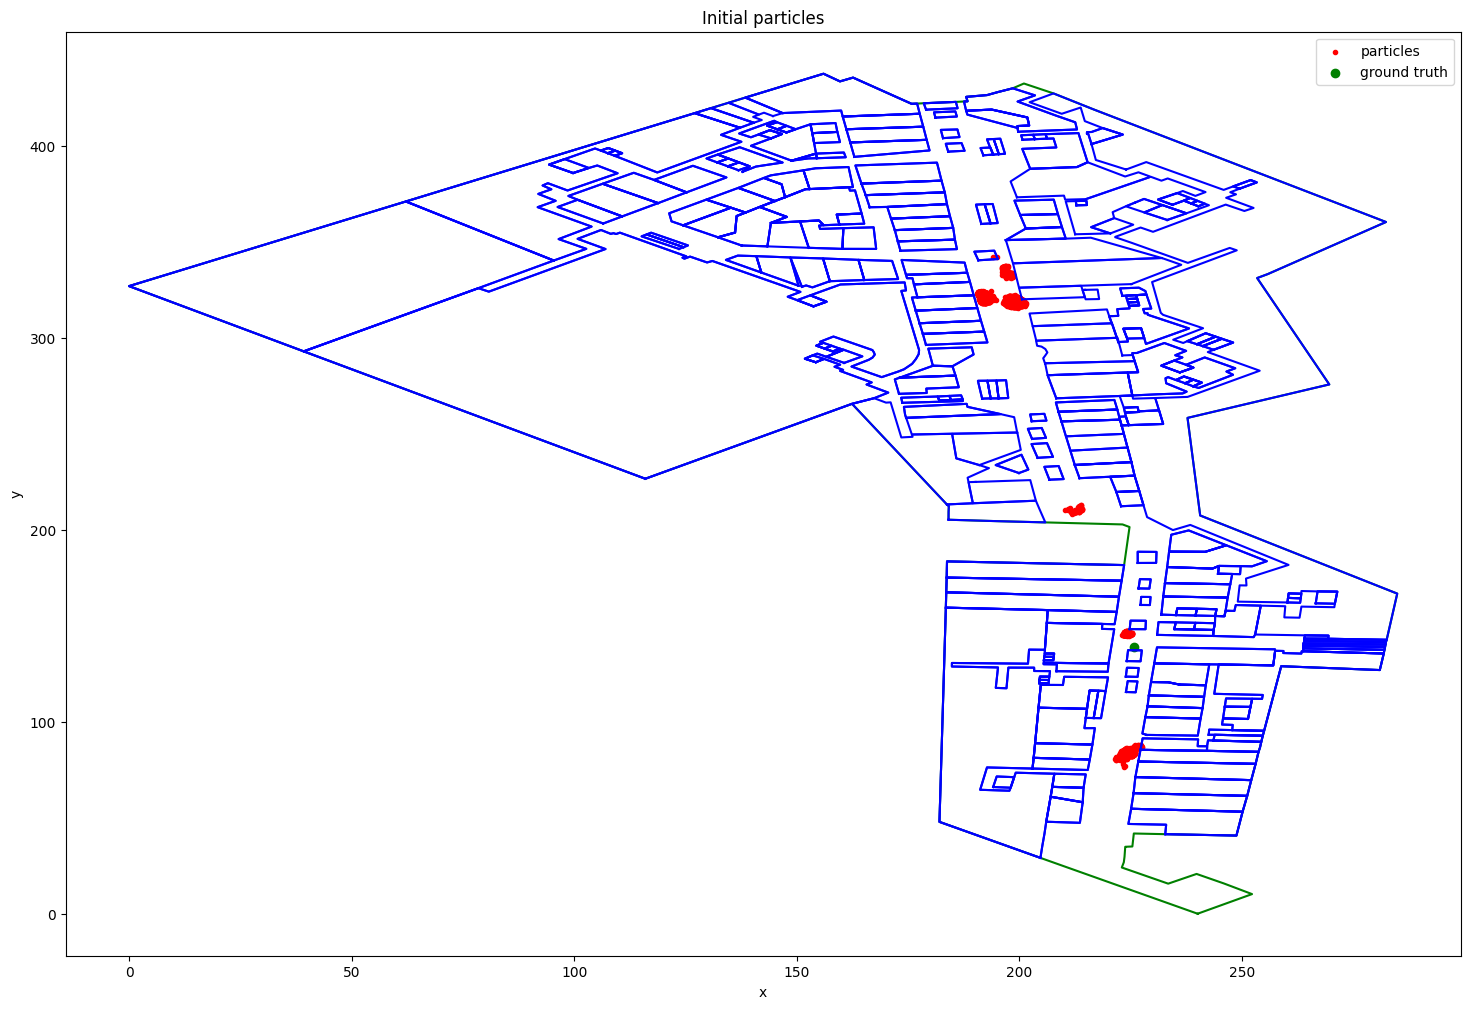

In [524]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Initial particles")

step = history[-1]

ax.scatter(
    step.particles[step.keep_mask][:, 0],
    step.particles[step.keep_mask][:, 1],
    marker=".",
    color="red",
    label="particles",
)
ax.scatter(
    r_gt_location[-1, 0],
    r_gt_location[-1, 1],
    marker="o",
    color="green",
    label="ground truth",
)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Create Artificial Waypoint Dataset

* The last step is to create an artificial waypoint dataset.

In [525]:
def inverse_scale(coords,
                  x_min,
                  y_min,
                  x_max,
                  y_max,
                  width_meter,
                  height_meter,
                  inplace=False):
  if not inplace:
    coords = coords.copy()

  coords[:, 0] = coords[:, 0] * (x_max - x_min) / width_meter + x_min
  coords[:, 1] = coords[:, 1] * (y_max - y_min) / height_meter + y_min

  return coords

In [526]:
track_waypoints = []

for step in history:
  step_point = step.particles[step.keep_mask, :2].mean(axis=0).tolist()
  step_time = ts[step.sample_index]
  track_waypoints.append((step_time, *step_point))

In [527]:
track_waypoints_df = pd.DataFrame(track_waypoints, columns=["sys_ts", "x", "y"])

In [528]:
unscaled = track_waypoints_df[["x", "y"]].values

In [529]:
artificial_location = inverse_scale(track_waypoints_df[["x", "y"]].values,
                                    x_min, y_min, x_max, y_max, width_meter, height_meter)

In [530]:
track_waypoints_df["x"], track_waypoints_df["y"] = inverse_rotate(artificial_location[:, 0], artificial_location[:, 1], rotation_angle_radians)

In [531]:
!mkdir -p ../../data/zee/train

In [532]:
track_name = os.path.basename(train_files[0])[:-len(".txt")]

In [533]:
os.makedirs(f"../../data/zee/train/{site_id}/{floor_id}/", exist_ok=True)

In [534]:
track_waypoints_df.to_csv(f"../../data/zee/train/{site_id}/{floor_id}/{track_name}_waypoint.csv", 
                          index=False,
                          header=True)

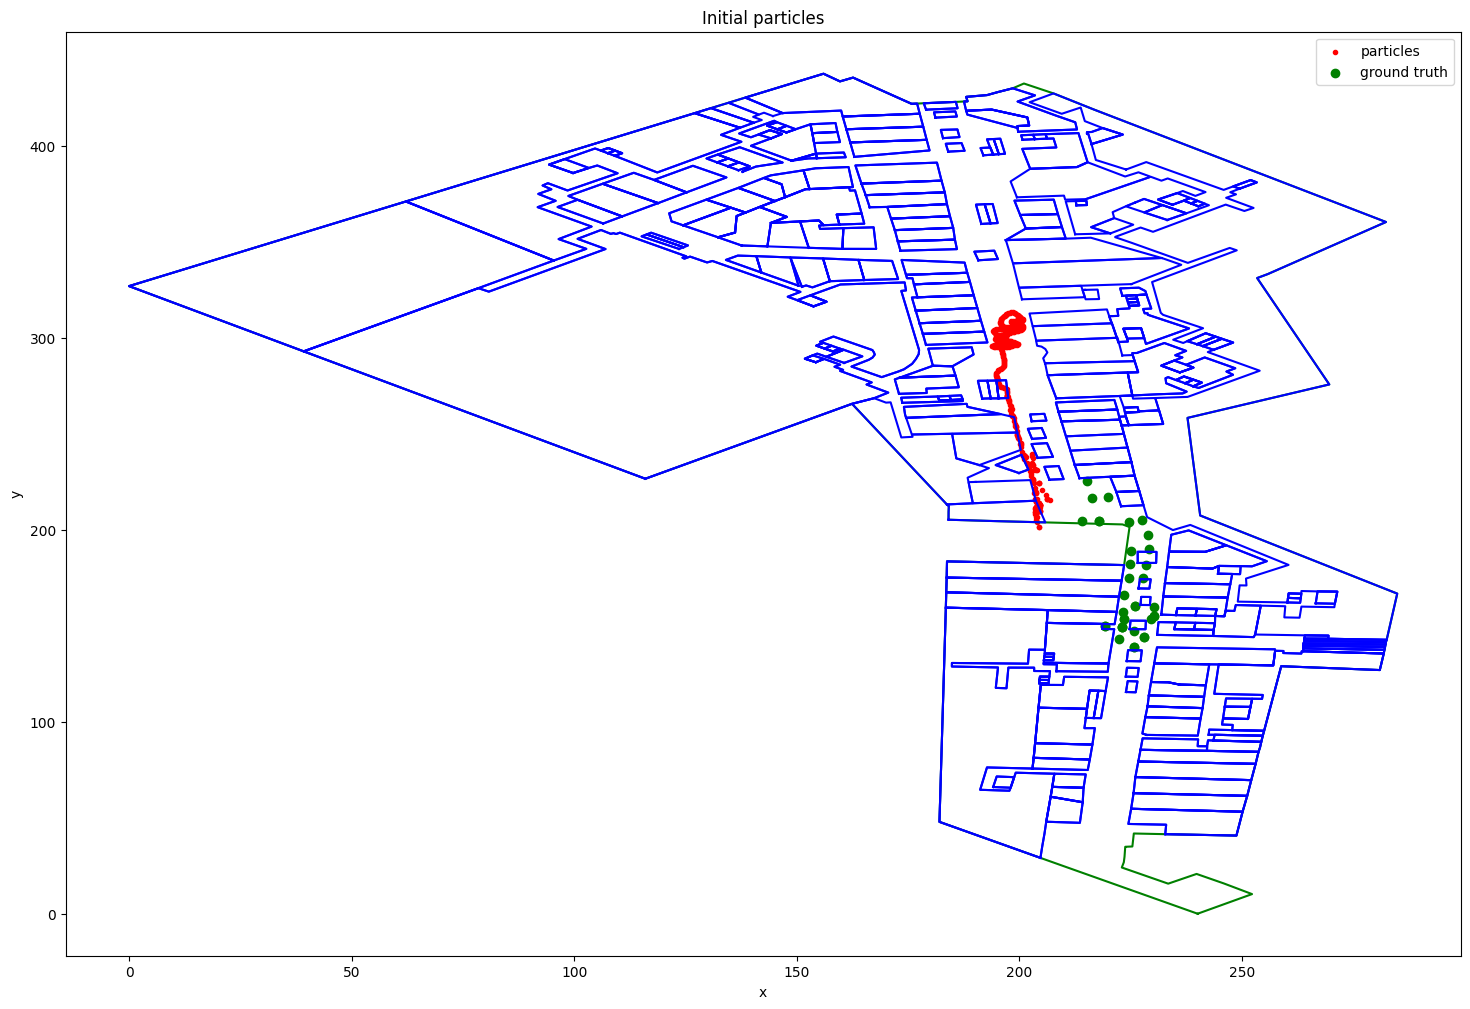

In [535]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Initial particles")

ax.scatter(
    unscaled[:, 0],
    unscaled[:, 1],
    marker=".",
    color="red",
    label="particles",
)
ax.scatter(
    r_gt_location[:, 0],
    r_gt_location[:, 1],
    marker="o",
    color="green",
    label="ground truth",
)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## Comparision with Manually Collected Data

In [536]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame,
                               track_wifi_df: pd.DataFrame,
                               max_offset_sec: int = 2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts
                                                   <= max_offset_millis)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1]
                                                    <= max_offset_millis)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]

  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[
      left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts -
                                                     prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (
      waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (
      waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(np.vstack([
      wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]
  ]).T,
                                  columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df

In [537]:
def extract_wifi_df(wifi: np.ndarray, verbose=False):
  wifi_schema = {
    "sys_ts": "system timestamp",
    "ssid": "the network name",
    "bssid": "the MAC address of the AP",
    "rssi": "RSSI",
    "freq": "Frequency",
    "last_seen_ts": "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  if verbose:
    print(f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}")
  return wifi_df

In [538]:
def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False):
  waypoint_schema = {
    "sys_ts": "System timestamp",
    "x": "Coordinate x (meter)",
    "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array, columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] - waypoint_df["sys_ts"].values[:-1]) / 1000
    print(f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s")

  return waypoint_df


In [539]:
waypoint_df = extract_waypoint_df(path_datas.waypoint)

In [540]:
wifi_df = extract_wifi_df(path_datas.wifi)

In [541]:
wifi_waypoint_df = interpolate_wifi_waypoints(waypoint_df, wifi_df, max_offset_sec=2)

In [542]:
zee_wifi_waypoint_df = interpolate_wifi_waypoints(track_waypoints_df, wifi_df, max_offset_sec=2)

In [543]:
merged = pd.merge(wifi_waypoint_df, zee_wifi_waypoint_df, on="sys_ts", suffixes=["_manual", "_zee"])

In [544]:
errors = np.linalg.norm(merged[["x_manual", "y_manual"]].values - merged[["x_zee", "y_zee"]].values,
                        axis=1)


In [545]:
errors.mean()

117.70670378894036